### Laboratorio 9 - Tutorial de Visualziación de Datos

Stefano Aragoni, Carol Arévalo, Luis Santos

---------

##### *Misión*

Utilizar visualizaciones para “contar una historia”. Mostrar qué países tienen una mayor proporción y cómo ha evolucionado en los últimos años. ¿Cómo se comparan las diferentes regiones del mundo? ¿Cómo está la situación en Guatemala, comparada al mundo? ¿Y comparada América Latina?

##### *Teoría*

Principios del diseño de visualización: simplicidad, claridad, precisión y eficiencia.

--------

##### *Importar librerías*
Como primer paso, se cargaron todas las librerías necesarias para el desarrollo del laboratorio.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Image
import pycountry
import pycountry_convert as pc
import geopandas as gpd
import matplotlib.pyplot as plt

##### *Cargar el Conjunto de Datos*

Posteriormente, se cargó el conjunto de datos en un dataframe de pandas, para poder visualizarlo.

In [2]:
# Carregando o dataset
dataset = pd.read_csv('dataset.csv')

# Mostrar las primeras 5 filas del dataset
dataset.head()

,Entity,Code,Year,Emissions
0,Afghanistan,AFG,1990,78.558522
1,Afghanistan,AFG,1991,79.335651
2,Afghanistan,AFG,1992,84.268804
3,Afghanistan,AFG,1993,85.247941
4,Afghanistan,AFG,1994,86.897834


In [3]:
# Función para obtener el continente de un país
def get_country_continent(location):

    if location in ['Brunei', 'Iran', 'Laos', 'Moldova', 'North Korea', 'Syria', 'Taiwan', 'Timor-Leste', 'Vietnam', 'South Korea']:
        return 'Asia'
    elif location in ['Bolivia', 'Venezuela']:
        return 'South America'
    elif location in ['Cape Verde', "Cote d'Ivoire", 'Democratic Republic of Congo', 'Tanzania', 'Swaziland', 'Western Sahara']:
        return 'Africa'
    elif location in ['British Virgin Islands', 'Falkland Islands', 'Netherlands Antilles', 'Saint Helena', 'Micronesia']:
        return 'Oceania'
    elif location in ['Russia', 'Serbia and Montenegro', 'Reunion']:
        return 'Europe'
    elif location in ['United States Virgin Islands']:
        return 'North America'

    try:
        country = pycountry.countries.get(name=location)
        if not country:
            country = pycountry.countries.get(alpha_2=location)
        if country:
            continent_code = pc.country_alpha2_to_continent_code(country.alpha_2)
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
            return continent_name
    except:
        pass
    return None

# Agregar columna de continente
dataset['Continent'] = dataset['Entity'].apply(get_country_continent)
dataset = dataset[dataset.Entity != 'World']

# Mostrar las primeras 5 filas del dataset
dataset.head(10)

,Entity,Code,Year,Emissions,Continent
0,Afghanistan,AFG,1990,78.558522,Asia
1,Afghanistan,AFG,1991,79.335651,Asia
2,Afghanistan,AFG,1992,84.268804,Asia
3,Afghanistan,AFG,1993,85.247941,Asia
4,Afghanistan,AFG,1994,86.897834,Asia
5,Afghanistan,AFG,1995,88.056318,Asia
6,Afghanistan,AFG,1996,88.851187,Asia
7,Afghanistan,AFG,1997,89.686852,Asia
8,Afghanistan,AFG,1998,90.079482,Asia
9,Afghanistan,AFG,1999,90.839404,Asia


Posteriormente, se analizó brevemente los datos presentes para determinar si existían valores nulos o **datos atípicos**. Se encontró que no existían valores nulos, pero sí existían datos atípicos.


En este caso, la mayoría de datos están entre 22 y 85. Por lo tanto, cualquier valor relativamente alto se considera un dato atípico. Se decidió eliminar estos datos atípicos para evitar que afecten el análisis. Por ejemplo, 309,631. 

In [4]:
# Revisar si existen valores atípicos
dataset.describe()

,Year,Emissions
count,5746.000000,5746.000000
mean,2002.500000,119.586307
std,7.500653,4202.392320
min,1990.000000,-19724.573980
25%,1996.000000,22.130752
50%,2002.500000,46.962415
75%,2009.000000,85.261741
max,2015.000000,309631.969600


In [5]:
# Remplazar valores atípicos por promedio de emisiones en el año por continente (sin contar ese país)

for index, row in dataset.iterrows():

    # Si el valor absoluto de las emisiones es mayor a 2500, entonces remplazar por el promedio de emisiones en el año (sin contar ese país)
    if abs(row['Emissions']) > 2500:

        year_row = row['Year']
        country_row = row['Entity']

        # Promedio de emisiones en el año (sin contar ese país)
        mean_year_wo_country = dataset[(dataset['Year'] == year_row) & (dataset['Entity'] != country_row)]['Emissions'].mean()

        signo = 1 if row['Emissions'] > 0 else -1
        dataset.at[index, 'Emissions'] = signo * mean_year_wo_country

---------------

##### *Historia*

El dataset utilizado contiene información sobre la proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos, que incluyen la agricultura, el cambio en el uso de la tierra y las emisiones relacionadas con la cadena de suministro de alimentos. Estas emisiones se calculan en función de la producción de alimentos, sin considerar el comercio internacional.

A continuación se presenta un mapa de calor que muestra la variación en las emisiones producidas por distintos países entre 1990 y 2015. Los países con emisiones más altas aparecen en tonos de rojo más oscuro, mientras que los países con emisiones más bajas aparecen en tonos de amarillo más claro. 

Como se puede observar, África y Sudamérica son los contientes que presentan emisiones más altas. Los países de estas regiones, en su mayoría, presentan un tono rojo oscuro. Esto indica que tienen una alta proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos. 

Asimismo, es importante mencionar que todos los países mundialmente presentan alguna tonalidad de rojo. Esto indica que todos los países presentan emisiones atribuibles a la producción de alimentos. Por lo tanto, es importante que todos los países tomen medidas para reducir estas emisiones.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/2266598806.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/2266598806.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_mapa = dataset.groupby(['Code']).sum().reset_index()


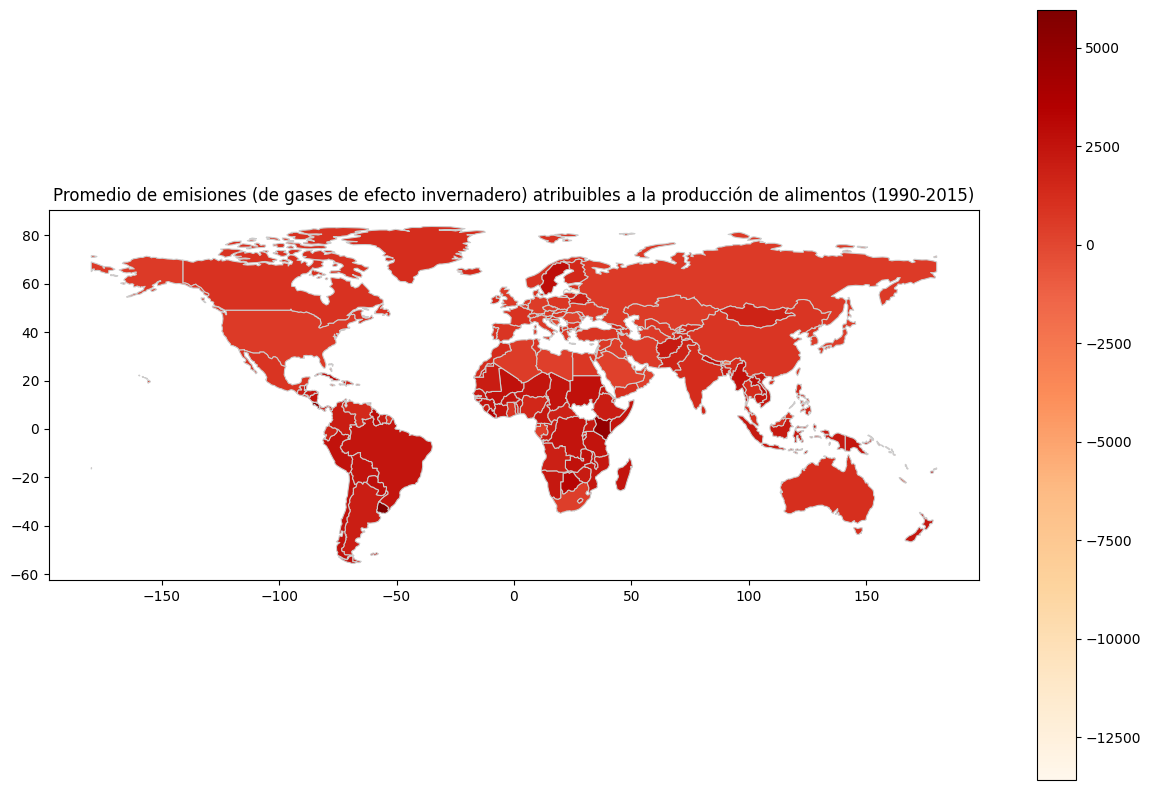

In [6]:
# Grafica de Mundo Comparando Emisiones de Paises

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
dataset_mapa = dataset.groupby(['Code']).sum().reset_index()

world_emissions = world.merge(dataset_mapa, left_on='iso_a3', right_on='Code', how='inner')


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world_emissions.plot(column='Emissions', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Promedio de emisiones (de gases de efecto invernadero) atribuibles a la producción de alimentos (1990-2015)')
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=world_emissions['Emissions'].min(), vmax=world_emissions['Emissions'].max()))
plt.show()

Posteriormente, se quiso analizar más a detalle los TOP 10 países con mayor proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos. Estos valores fueron calculados sumando las emisiones de cada país en el periodo de tiempo de 1990 a 2015. 

Como se puede observar a continuación, el país con mayor proporción de emisiones es Micronesia, seguido de Uruguay y luego Costa Rica. En este caso, la diferencia entre los primeros tres lugares es relativamente baja. Esto indica que, aunque Micronesia tiene la mayor proporción de emisiones, Uruguay y Costa Rica no se quedan atrás.

Cabe destacar que Uruguay y Costa Rica son los únicos países latinoamericanos en el TOP 10. En realidad, la mayoría de países que más emisiones producen son africanos. Esto corrobora lo que se observó en el mapa de calor, donde la mayoría de países africanos presentaban tonos rojos oscuros.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/969840848.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_country = dataset.groupby('Entity').sum().reset_index()


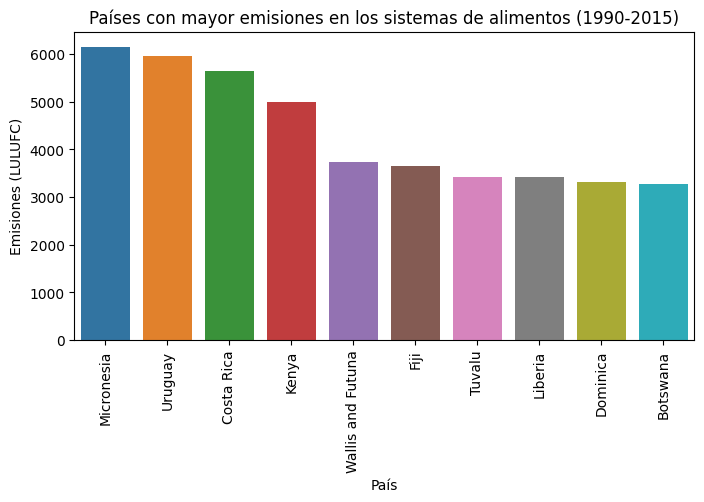

In [7]:
# Gráfica comparando los paises con mayor proporción de emisiones en los sistemas de alimentos

# Sumar las emisiones de cada país
dataset_country = dataset.groupby('Entity').sum().reset_index()

# Ordenar los países por emisiones
dataset_country = dataset_country.sort_values(by=['Emissions'], ascending=False)

# Graficar los 10 países con mayor emisión
plt.figure(figsize=(8,4)) 
sns.barplot(x='Entity', y='Emissions', data=dataset_country.head(10))
plt.xticks(rotation=90)
plt.xlabel('País')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Países con mayor emisiones en los sistemas de alimentos (1990-2015)')
plt.show()

Al analizar la evolución de las emisiones a lo largo de los años, se puede observar un declive general en las emisiones generadas mundialmente. Esto indica que, aunque la proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos es alta, se ha logrado reducir en los últimos años.

Más específicamente, a partir del año 2003 se puede observar una reducción en las emisiones. A pesar de que han habido incrementos en ciertos años, la tendencia general es a la baja. Esto indica que los países están tomando medidas para reducir las emisiones de gases de efecto invernadero atribuibles a la producción de alimentos.

Por ejemplo, en la actualidad se ha vuelto muy popular el veganismo. Esto ha llevado a que muchas personas dejen de consumir productos de origen animal, lo que ha reducido la producción de estos productos. Asimismo, se ha implementado nuevos mecanismos y técnicas en esta industria para reducir las emisiones producidas por animales, como las vacas.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/3657988075.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_year = dataset.groupby('Year').sum().reset_index()


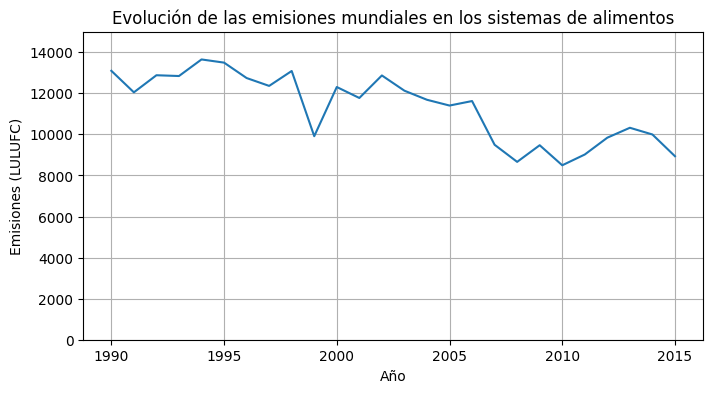

In [8]:
# Grafica de evolución de las emisiones a lo largo de los años

# Sumar las emisiones de cada año
dataset_year = dataset.groupby('Year').sum().reset_index()

# Graficar las emisiones a lo largo de los años
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='Emissions', data=dataset_year)
plt.xlabel('Año')
plt.ylabel('Emisiones (LULUFC)')
plt.ylim(0, 15000)
plt.grid(True)
plt.title('Evolución de las emisiones mundiales en los sistemas de alimentos')
plt.show()

Para analizar la evolución de las emisiones con el paso del tiempo (por contienente), se optó por promediar las emisiones de cada continente en el periodo de tiempo de 1990 a 2015. Esto permitió observar la tendencia general de las emisiones de cada continente. 

- No es razonable sumar las emisiones de cada continente, ya que hay continentes que tienen más países que otros. Por lo tanto, se optó por promediar las emisiones de cada continente.

En este caso, se puede observar que Sudamérica es el continente que presenta las emisiones más altas. Dicho continente ha tenido la mayor cantidad de emisiones más del 80% de los años analizados. Esto posiblemente se debe a que todos los países de Sudamérica son países en vías de desarrollo. Por lo tanto, suelen depender principalmente de la agricultura para generar ingresos. Como resultado, se produce una gran cantidad de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos.

Cabe destacar que África también presenta una gran cantidad de emisiones. Sin embargo, no es tan alta como la de Sudamérica. Esto posiblemente se debe a que ciertas regiones de África no son aptas para la agricultura. Por lo tanto, no se produce una gran cantidad de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos. Por lo tanto, al promediar las emisiones de África, se obtiene un valor relativamente menor.

Asimismo, se puede observar que del 2010 al 2013, Oceania ha tenido un aumento significativo en las emisiones promedio. Sin embargo, los otros contienentes (como Asia, África, Norte América) se han mantenido relativamente estables. Europa es el único continente que se ha esforzado activamente desde el 2005 para reducir las emisiones. En realidad, según los datos, han logrado llegar a los números negativos. Esto indica que no solo han reducido las emisiones, sino que han logrado producir más alimentos sin generar emisiones. Esto puede deberse a que han implementado nuevas técnicas y mecanismos para reducir las emisiones producidas por la producción de alimentos.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/3208029594.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_continent = dataset.groupby(['Continent', 'Year']).mean().reset_index()


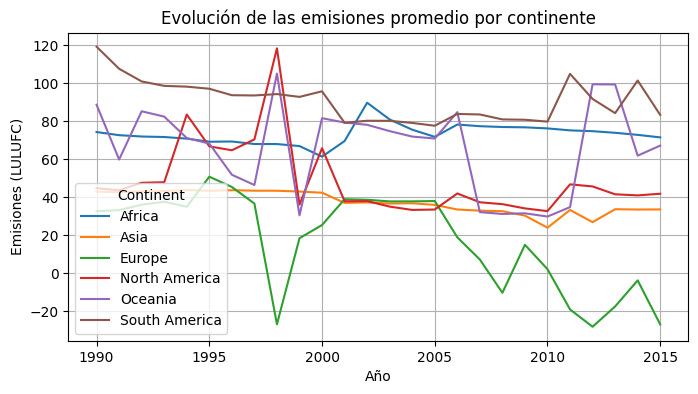

In [9]:
# Grafica comparando los diferentes contienenetes con el paso de los años

# Sumar las emisiones de cada continente
dataset_continent = dataset.groupby(['Continent', 'Year']).mean().reset_index()

# Graficar las emisiones a lo largo de los años
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='Emissions', hue='Continent', data=dataset_continent)
plt.grid(True)
plt.xlabel('Año')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Evolución de las emisiones promedio por continente')
plt.show()

Al analizar el promedio de emisiones por continente (entre 1990 y 2015), nuevamente se puede observar que Sudamérica es el continente que presenta las emisiones más altas. Esto indica que, en general, los países de Sudamérica tienen una alta proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos.

Asimismo, África, que se encuentra en segundo lugar, presenta una proporción de emisiones relativamente alta. Nuevamente confirmando lo inicialmente observado en el mapa de calor.


Finalmente, cabe destacar que Europa se encuentra en último lugar. Esto indica que los países de Europa tienen una proporción de emisiones relativamente baja. Esto posiblemente se debe a que han implementado nuevas técnicas y mecanismos para reducir las emisiones producidas por la producción de alimentos. Por tal motivo, han logrado contrarestar las emisiones producidas en años anteriores y así reducir su huella en el medio ambiente.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/2606063559.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_continent = dataset.groupby(['Continent']).mean().reset_index()


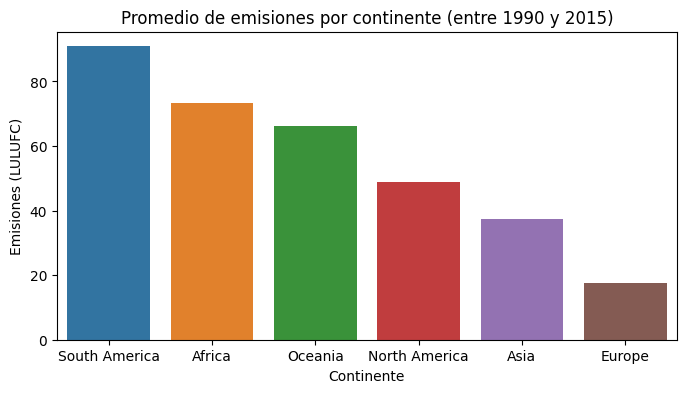

In [10]:
# Grafica comparando los diferentes contienenetes (1990-2015)

# Sumar las emisiones de cada continente
dataset_continent = dataset.groupby(['Continent']).mean().reset_index()

# Ordenar los continentes por emisiones
dataset_continent = dataset_continent.sort_values(by=['Emissions'], ascending=False)

# Graficar las emisiones
plt.figure(figsize=(8,4))
sns.barplot(x='Continent', y='Emissions', data=dataset_continent)
plt.xlabel('Continente')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Promedio de emisiones por continente (entre 1990 y 2015)')
plt.show()

Más específicamente, al comparar la evolución de las emisiones de Guatemala con las emisiones mundiales (promedio), se puede observar que Guatemala produce emisiones más altas que el promedio mundial. Esto indica que Guatemala tiene una proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos relativamente alta.

Como se puede observar a continuación, Guatemala y el promedio global ambos siguen las mismas tendencias. Sin embargo, Guatemala siempre se encuentra por encima del promedio global. Nuevamente, esto posiblemente debido a que Guatemala y su economía se basa principalmente en la agricultura y la ganaería. Asimismo, ya que no existen regulaciones estrictas en Guatemala, es posible que se produzcan más emisiones que en otros países.

Finalmente, es importante destacar que Guatemala y el promedio global tienen una tendencia negativa. Esto posiblemente significa que se están tomando medidas para reducir las emisiones de gases de efecto invernadero atribuibles a la producción de alimentos. Por lo tanto, se espera que en los próximos años las emisiones de Guatemala y el promedio global sigan disminuyendo.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/2915657386.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_except_guatemala = dataset_except_guatemala.groupby('Year').mean().reset_index()


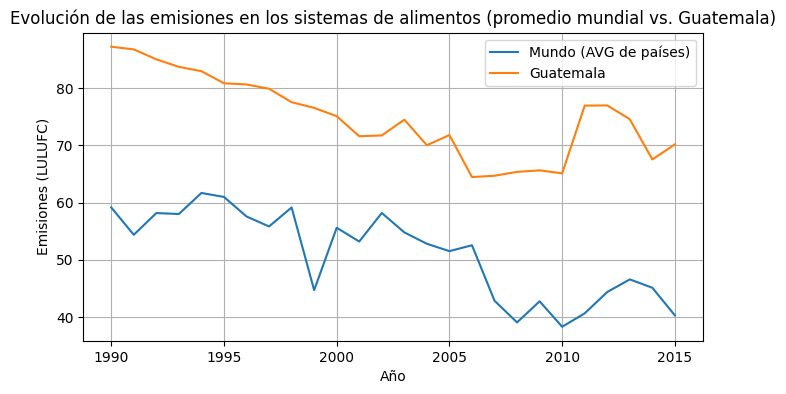

In [11]:
# Comparar las emisiones del Mundo vs. Guatemala

# Dataset excepto Guatemala
dataset_except_guatemala = dataset[dataset['Entity'] != 'Guatemala']

# AVG las emisiones de cada año
dataset_except_guatemala = dataset_except_guatemala.groupby('Year').mean().reset_index()

# Filtrar los datos de Guatemala
dataset_guatemala = dataset[dataset['Entity'] == 'Guatemala']

# Graficar las emisiones de Latinoamerica vs. Guatemala
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='Emissions', data=dataset_except_guatemala, label='Mundo (AVG de países)')
sns.lineplot(x='Year', y='Emissions', data=dataset_guatemala, label='Guatemala')
plt.grid(True)
plt.xlabel('Año')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Evolución de las emisiones en los sistemas de alimentos (promedio mundial vs. Guatemala)')
plt.show()

Por otro lado, al comparar la evolución de las emisiones de Guatemala con las emisiones latinoamericanas (promedio), se puede observar que Guatemala está por debajo del promedio latinoamericano. Esto indica que Guatemala, a diferencia de otros países latinoamericanos, tiene una proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos relativamente baja.

Esto posiblemente se debe al tamaño de Guatemala. Este país es relativamente pequeño, por lo cual -claramente- no tiene la misma capacidad de producir tantos alimentos como otros países latinoamericanos, como Brasil, Chile y Perú. Por lo tanto, es razonable que Guatemala tenga una proporción de emisiones relativamente baja (a comparación de otros países latinoamericanos).

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/273448081.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_latinoamerica = dataset_latinoamerica.groupby('Year').mean().reset_index()


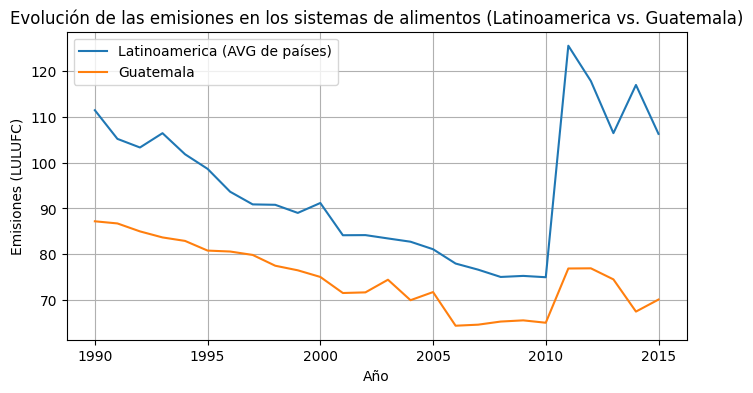

In [12]:
# Comparar las emisiones de Latinoamerica vs. Guatemala

# Lista de países de Latinoamerica
latinoamerica_array = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Haiti', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela']

# Filtrar los países de Latinoamerica
dataset_latinoamerica = dataset[dataset['Entity'].isin(latinoamerica_array)]

# AVG las emisiones de cada año
dataset_latinoamerica = dataset_latinoamerica.groupby('Year').mean().reset_index()

# Filtrar los datos de Guatemala
dataset_guatemala = dataset[dataset['Entity'] == 'Guatemala']

# Graficar las emisiones de Latinoamerica vs. Guatemala
plt.figure(figsize=(8,4))
sns.lineplot(x='Year', y='Emissions', data=dataset_latinoamerica, label='Latinoamerica (AVG de países)')
sns.lineplot(x='Year', y='Emissions', data=dataset_guatemala, label='Guatemala')
plt.grid(True)
plt.xlabel('Año')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Evolución de las emisiones en los sistemas de alimentos (Latinoamerica vs. Guatemala)')
plt.show()

Al comparar las emisiones promedio de los países latinoamericanos (entre 1990 y 2015), nuevamente se puede observar a Uruguay y a Costa Rica en los primeros lugares. Esto indica que estos países tienen una proporción de emisiones de gases de efecto invernadero atribuibles a la producción de alimentos relativamente alta.

Sin embargo, cabe destacar que los últimos países son: Dominican Republic, Ecuador, Haiti, Venezuela, El Salvador, México. Varios de estos países tienen problemas socioeconómicos y políticos, así como pobreza extrema. Otros son de tamaño relativamente pequeño. Por lo tanto, es razonable que estos países tengan una proporción de emisiones relativamente baja (a comparación de otros países latinoamericanos).

Guatemala, por otro lado, se encuentra en la posición 14 de 20. Varios de los países por encima de Guatemala son mucho más grandes y tienen una economía más desarrollada. Por lo tanto, es razonable que estos países tengan una proporción de emisiones relativamente alta (a comparación de Guatemala). 

Sin embargo, existen otros países centroamericanos que tienen una proporción de emisiones más alta que Guatemala. Honduras y Nicaragua, por ejemplo, tienen tamaño similar a Guatemala pero tienen una proporción de emisiones más alta. Esto posiblemente se debe a que uno, produce más alimentos que Guatemala y dos, no tiene regulaciones estrictas para reducir las emisiones producidas por la producción de alimentos.

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_81444/4156079404.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset_latinoamerica = dataset_latinoamerica.groupby('Entity').sum().reset_index()


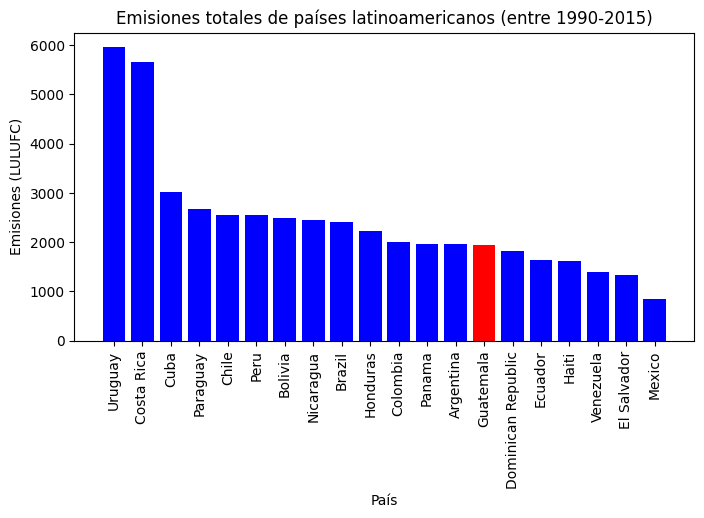

In [13]:
# Comparar las emisiones de los países de Latinoamerica vs. Guatemala

# Lista de países de Latinoamerica
latinoamerica_array = ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay', 'Venezuela']

# Filtrar los datos de Latinoamerica
dataset_latinoamerica = dataset[dataset['Entity'].isin(latinoamerica_array)]

# Sumar las emisiones de cada país
dataset_latinoamerica = dataset_latinoamerica.groupby('Entity').sum().reset_index()

# Ordenar los países por emisiones
dataset_latinoamerica = dataset_latinoamerica.sort_values(by=['Emissions'], ascending=False)

# Graficar las emisiones de Latinoamerica vs. Guatemala
plt.figure(figsize=(8,4))

# Hacer todas las barras del mismo color, excepto la de Guatemala
colors = ['b' for i in range(len(dataset_latinoamerica))]
colors[13] = 'r'
plt.bar(dataset_latinoamerica['Entity'], dataset_latinoamerica['Emissions'], color=colors)

plt.xticks(rotation=90)
plt.xlabel('País')
plt.ylabel('Emisiones (LULUFC)')
plt.title('Emisiones totales de países latinoamericanos (entre 1990-2015)')
plt.show()


---------

##### *Reflexión*

- ***¿Qué experiencias individuales han tenido los miembros de su grupo?***

A través de esta actividad, logramos comprender la importancia de la visualización de datos y cómo estos gráficos pueden ser utilizados para contar una historia. Más específicamente, nos permitió identificar qué tipo de gráficas utilizar en diferentes situaciones. Por ejemplo, a través del artículo y el material brindado, logramos refrescar nuestra memoria sobre los cuatro tipos de gráficas principales: comparación, composición, relaciones y distribuciones. 

Asimismo, esta actividad generó un diálogo entre los miembros del grupo. Esto debido a que tuvimos que debatir y llegar a un consenso sobre qué gráficas utilizar para contar la historia de los datos. En ocasiones era claro qué gráfica era la más apropiada, sin embargo, era complicado determinar qué datos utilizar para contar la historia. Por ejemplo, para comparar las emisiones de Guatemala vs. Latinoamérica, no estabamos seguros si sumabamos las emisiones de todos los países de Latinoamérica o si promediabamos las emisiones de los mismos.

En mi caso (Stefano Aragoni), creo que el procesamiento de datos es sumamente importante para poder contar una historia. Por ejemplo, el dataset original no clasificaba a los países por región. Por lo tanto, tuvimos que utilizar una librería de Python para poder clasificar a los países por región. Esto me permitió poder comparar las emisiones de Guatemala vs. Latinoamérica, por ejemplo. 

En conclusión, esta experiencia me permitió entender la relevancia del procesamiento de datos para generar visualizaciones interesantes, y que no solo muestren los datos originales.

En mi opinión (Carol Arévalo), la calidad visual de una gráfica es sumamente importante para que el lector pueda entender claramente la historia que se quiere contar. Por ejemplo, en el artículo que leímos, se mencionaba que la calidad visual de una gráfica se puede medir a través de cuatro principios: simplicidad, claridad, precisión y eficiencia.

Para esto, tuvimos que asegurarnos que los gráficos realizados no fueran muy cargados de información, que los colores fueran adecuados, que los títulos y los ejes fueran claros, que la información fuera precisa y que la gráfica fuera eficiente. Muchas veces las gráficas no presentan esta información, y se dificulta entender la historia que se quiere contar.

Finalmente, yo (Luis Santos) creo la descripción de las gráficas es sumamente importante para poder ayudarle al lector a comprender lo que está viendo. Asimismo, creo que es importante explicar de forma ética el contenido de las mismas. A veces las gráficas pueden ser engañosas o simplemente son confusas, y esto puede llevar a que el lector no entienda la historia que se quiere contar. Por lo tanto, es importante que la descripción de las gráficas sea clara y concisa.

- ***Comenten sobre la importancia de la ética en la visualización de datos, evitando visualizaciones engañosas o que lleven a interpretaciones erróneas. Proporcionar casos notorios***

En nuestra opinión, la ética es sumamente importante en la visualización de datos. Esto debido a que las gráficas pueden ser utilizadas para contar una historia, pero también pueden ser utilizadas para engañar a los lectores. 

Esto puede ser sumamente peligroso, debido a que las gráficas también son utilziadas para influir en personas. Más específicamente, se pueden utilizar para influir en las decisiones de las personas, así como en su perspectiva sobre un tema. Por lo tanto, es importante que las gráficas sean éticas y no engañosas.

A veces puede ser que una gráfica no sea engañosa, pero que sea confusa. Esto también puede llevar a que el lector no entienda la historia que se quiere contar. Por lo tanto, es importante que la descripción de las gráficas sea clara y concisa. Sin embargo, siempre es importante que el lector tenga un pensamiento crítico y que no se deje influenciar por una gráfica.

Por ejemplo, a continuación se puede observar un ejemplo real de muertes por armas de fuego en Florida (EEUU). En esta gráfica se intenta que el lector piense que gracias a la ley "Stand Your Ground" (que permite a los ciudadanos utilizar armas de fuego para defenderse), las muertes por armas de fuego han disminuido.

Sin embargo, el eje Y está al revés. Por tal razón, si alguien no se da cuenta que el eje Y está al revés, podría pensar que la ley "Stand Your Ground" ha sido efectiva para disminuir las muertes por armas de fuego. 

Esta es en realidad la interpretación que el autor de la gráfica quiere que el lector tenga. Esto con un propósito político, ya que el autor quiere que los votantes apoyen legislaciones que permitan a los ciudadanos utilizar armas de fuego más fácilmente.

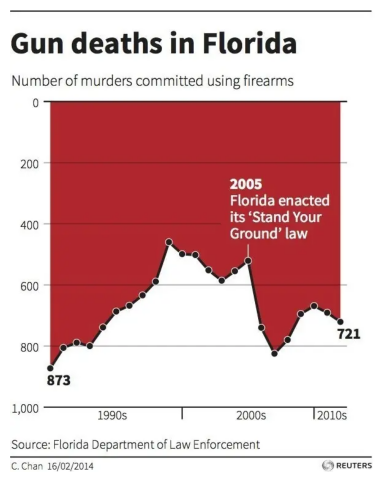

In [14]:
# Mostrar la imagen
plt.figure(figsize=(10,6))
plt.imshow(plt.imread('misleading.webp'))
plt.axis('off')
plt.show()


Fox News es una organización que comúnmente utiliza este tipo de gráficas para engañar a sus televidentes. Por ejemplo, a continuación se puede observar una gráfica que se realizó a principios del 2020, en donde se muestra el número de casos de COVID-19 con el paso del tiempo. 

Esta grafica, si el lector no lee el eje Y, podría pensar que el número de casos no aumentó significantemente. Sin embargo, el eje Y está escalado de forma que el número de casos no se vea tan grande. Va de 0, a 5, 20, 35, 50, a 65k. De esta forma, el lector podría pensar que el número de casos no aumentó tanto.

Al graficar estos datos con una escala lineal, se puede observar que el número de casos aumentó inimaginablemente. Sin embargo, Fox News tenía la intención de decirle a sus televidentes que el virus era algo que no debían de preocuparse.

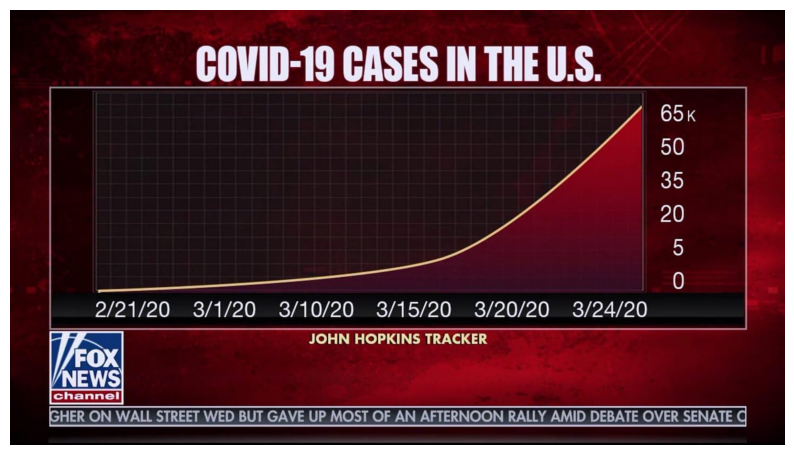

In [15]:
# Mostrar la imagen
plt.figure(figsize=(10,6))
plt.imshow(plt.imread('misleading2.jpg'))
plt.axis('off')
plt.show()